<a href="https://colab.research.google.com/github/tfjgeorge/ntk_alignment/blob/master/NTK_alignment_viz_on_toy_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/tfjgeorge/nngeometry.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tfjgeorge/nngeometry.git to /tmp/pip-req-build-4llg417b
  Running command git clone --filter=blob:none --quiet https://github.com/tfjgeorge/nngeometry.git /tmp/pip-req-build-4llg417b
  Resolved https://github.com/tfjgeorge/nngeometry.git to commit ba2dcb161b2f80f32bbd6932ffae6be545634952
  Preparing metadata (setup.py) ... done
  Created wheel for nngeometry: filename=nngeometry-0.2.2-py3-none-any.whl size=27114 sha256=b02b7a0c2577046c42766fdbd5d0f730b7378f559d6e967558eb27310183d0e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-i2qe_5eu/wheels/be/fb/c6/07bd5a8b72caba42d2dd5f66b562a2620fc02ec4ae44e79181
Successfully built nngeometry


In [ ]:
from collections import namedtuple

Args = namedtuple('Args', 'n_train lr max_iterations l2 loss flipped test_resolution dataset')
args = Args(dataset='disk', # ['disk', 'disk_flip_vertical', 'yinyang1', 'yinyang2']
            n_train=50,
            lr=5e-2,
            max_iterations=3000,
            l2=0.,
            loss='ce',
            flipped=0.,
            test_resolution=60)


In [ ]:
import torch
import torch.nn as nn
import copy
import numpy as np
import argparse
from torch.utils.data import (TensorDataset, DataLoader)
from nngeometry.generator import Jacobian
from nngeometry.object import PushForwardDense, PVector
import pickle as pkl
import matplotlib.pyplot as plt

r = (2 / np.pi)**.5
acc_step = .125

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'Using device: {device}')

def gen_model():
    lin1 = nn.Linear(2, 60)
    lin2 = nn.Linear(60, 60)
    lin3 = nn.Linear(60, 60)
    lin4 = nn.Linear(60, 1)
    model = nn.Sequential(lin1, nn.ReLU(), lin2, nn.ReLU(), lin3, nn.ReLU(), lin4)
    model.to(device)
    return model

class Recorder():
    def __init__(self):
        self.values = dict()

    def save(self, key, val, i=None):
        if i is not None:
            val = (i, val)
        if key in self.values.keys():
            self.values[key].append(val)
        else:
            self.values[key] = [val]

    def get(self, key):
        return self.values[key]

def get_jacobian(x, model):
    loader = DataLoader(TensorDataset(x), batch_size=x.size(0))
    pf = PushForwardDense(Jacobian(model), examples=loader)
    return pf.get_dense_tensor()[0]

iterations_record = np.round(10. ** np.arange(0, 10, .1))
def do_record(it):
    return it in iterations_record

def train(recorder, model, lr, iterations, x_train, y_train,
          x_test, y_test, loss_fn, l2_reg=0.):

    ntks = {
        'iterations': [],
        'train_acc': [],
        'f_hat_test': [],
        'jacobian': [],
    }
    next_acc_milestone = .5

    for i in range(iterations+1):

        w = PVector.from_model(model)

        with torch.no_grad():
            f_hat_test = model(x_test)[:, 0]
            loss_test, _ = loss_fn(f_hat_test, y_test)
            acc_test = ((y_test * f_hat_test) > 0).float().mean()
            recorder.save('test_loss', loss_test.item())
            recorder.save('test_acc', acc_test.item())

        if do_record(i) and i > 0:
            print(f'iteration {i}, train_loss: {loss_train.item()}, train_acc: {acc_train.item()}')

        f_hat_train = model(x_train)[:, 0]
        model.zero_grad()

        loss_train, grad_f = loss_fn(f_hat_train, y_train)
        acc_train = ((y_train * f_hat_train) > 0).float().mean()

        recorder.save('train_loss', loss_train.item())
        recorder.save('train_acc', acc_train.item())

        if i == 0 or recorder.get('train_acc')[-1] >= next_acc_milestone or i == (iterations - 1):
            # exract test ntk
            print(f'Extracting tangent features at iteration={i} for acc={next_acc_milestone}')
            ntks['jacobian'].append(get_jacobian(x_test, model))
            ntks['iterations'].append(i)
            ntks['train_acc'].append(recorder.get('train_acc')[-1])
            ntks['f_hat_test'].append(f_hat_test)
            next_acc_milestone += acc_step

        # compute gradients
        f_hat_train.backward(grad_f)
        grad_w = PVector.from_model_grad(model).detach()

        # update:
        ((1 - lr * l2_reg) * w.detach() - lr * grad_w).copy_to_model(model)

    return ntks


def mseloss(pred, target):
    loss = .5 * ((pred - target)**2).mean()
    grad_f = (pred - target) / pred.size(0)
    return loss, grad_f

def celoss(pred, target):
    target = (target + 1) / 2 # to 0-1
    sigm = torch.sigmoid(pred)
    log_sigm = torch.nn.functional.logsigmoid(pred)
    log_1_minus_sigm = torch.nn.functional.logsigmoid(-pred)
    loss = -(target * log_sigm + (1 - target) * log_1_minus_sigm).mean()
    grad_f = (sigm - target) / pred.size(0)
    return loss, grad_f

Using device: cuda


In [ ]:
def generate_disk_dataset(n_train=100, test_resolution=100, p=0, half=False):
    # p: proportion of flipped labels
    x_train = (torch.rand(100, 2) - .5) * 2
    y_train = (x_train[:, 0]**2 + x_train[:, 1]**2 < r**2) * 2 - 1

    x_test_x, x_test_y = np.mgrid[-1:1:test_resolution*1j, -1:1:test_resolution*1j]
    x_test = np.vstack((x_test_x.flatten(), x_test_y.flatten())).T
    x_test = torch.tensor(x_test, dtype=torch.float)
    y_test = ((x_test[:, 0]**2 + x_test[:, 1]**2 < r**2) * 2 - 1)

    if half:
        y_train *= 1 - 2 * (x_train[:, 1] > 0)
        y_test *= 1 - 2 * (x_test[:, 1] > 0)

    flipped_indices = np.random.choice(np.arange(n_train), size=int(p * n_train))
    y_train[flipped_indices] *= -1

    return (x_train.to(device), y_train.to(device),
            x_test.to(device), y_test.to(device))

def generate_yinyang_dataset(n_train=100, test_resolution=100, p=0, variant=1):
    # p: proportion of flipped labels

    if variant == 1:
        c_1 = (.5, -.5)
        c_2 = (-.5, .5)
        r = .3
    elif variant == 2:
        c_1 = (-.5, -.5)
        c_2 = (-.5, .5)
        r = .3

    x_train = (torch.rand(100, 2) - .5) * 2
    y_train = 1 - 2 * (x_train[:, 1] > 0)
    y_train *= 1 - 2 * (torch.norm(x_train - torch.tensor(c_1), dim=1) < r)
    y_train *= 1 - 2 * (torch.norm(x_train - torch.tensor(c_2), dim=1) < r)

    x_test_x, x_test_y = np.mgrid[-1:1:test_resolution*1j, -1:1:test_resolution*1j]
    x_test = np.vstack((x_test_x.flatten(), x_test_y.flatten())).T
    x_test = torch.tensor(x_test, dtype=torch.float)
    y_test = 1 - 2 * (x_test[:, 1] > 0)
    y_test *= 1 - 2 * (torch.norm(x_test - torch.tensor(c_1), dim=1) < r)
    y_test *= 1 - 2 * (torch.norm(x_test - torch.tensor(c_2), dim=1) < r)

    flipped_indices = np.random.choice(np.arange(n_train), size=int(p * n_train))
    y_train[flipped_indices] *= -1

    return (x_train.to(device), y_train.to(device),
            x_test.to(device), y_test.to(device))

In [ ]:
cmap = 'RdYlGn'

def custom_imshow(axis, ys, center=False):
    if center:
        minmax = torch.max(torch.abs(ys)).item()
        axis.imshow(ys.cpu().reshape(args.test_resolution, args.test_resolution).t(),
                    interpolation=None, cmap=cmap, extent=(-1, 1, -1, 1), alpha=.5,
                    origin='lower', vmin=-minmax, vmax=minmax)
    else:
        axis.imshow(ys.cpu().reshape(args.test_resolution, args.test_resolution).t(),
                    interpolation=None, cmap=cmap, extent=(-1, 1, -1, 1), alpha=.5,
                    origin='lower')

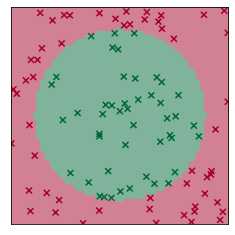

In [ ]:
if args.dataset == 'yinyang1':
    x_train, y_train, x_test, y_test = generate_yinyang_dataset(n_train=args.n_train, p=args.flipped, test_resolution=args.test_resolution, variant=1)
elif args.dataset == 'yinyang2':
    x_train, y_train, x_test, y_test = generate_yinyang_dataset(n_train=args.n_train, p=args.flipped, test_resolution=args.test_resolution, variant=2)
elif args.dataset == 'disk':
    x_train, y_train, x_test, y_test = generate_disk_dataset(n_train=args.n_train, p=args.flipped, test_resolution=args.test_resolution)
elif args.dataset == 'disk_flip_vertical':
    x_train, y_train, x_test, y_test = generate_disk_dataset(n_train=args.n_train, p=args.flipped, test_resolution=args.test_resolution, half=True)

plt.figure()
custom_imshow(plt.gca(), y_test)
plt.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
plt.xticks([]); plt.yticks([])
plt.show()

In [ ]:
x_test.shape

torch.Size([3600, 2])

In [ ]:
model = gen_model()
model.train()
recorder = Recorder()


if args.loss == 'mse':
    loss_fn = mseloss
elif args.loss == 'ce':
    loss_fn = celoss


ntks = train(recorder, model, args.lr, args.max_iterations, x_train, y_train,
             x_test, y_test, loss_fn, l2_reg=args.l2)

Extracting tangent features at iteration=0 for acc=0.5
iteration 1, train_loss: 0.6992541551589966, train_acc: 0.4599999785423279
iteration 2, train_loss: 0.6987239122390747, train_acc: 0.4599999785423279
iteration 3, train_loss: 0.6982133984565735, train_acc: 0.4399999976158142
iteration 4, train_loss: 0.6977207064628601, train_acc: 0.4599999785423279
iteration 5, train_loss: 0.697241485118866, train_acc: 0.4399999976158142
iteration 6, train_loss: 0.6967794895172119, train_acc: 0.41999998688697815
iteration 8, train_loss: 0.695904552936554, train_acc: 0.4399999976158142
iteration 10, train_loss: 0.6950932741165161, train_acc: 0.35999998450279236
iteration 13, train_loss: 0.6939694285392761, train_acc: 0.4599999785423279
iteration 16, train_loss: 0.6929689049720764, train_acc: 0.5399999618530273
iteration 20, train_loss: 0.6917945742607117, train_acc: 0.5399999618530273
iteration 25, train_loss: 0.6905171871185303, train_acc: 0.5399999618530273
iteration 32, train_loss: 0.689002692699

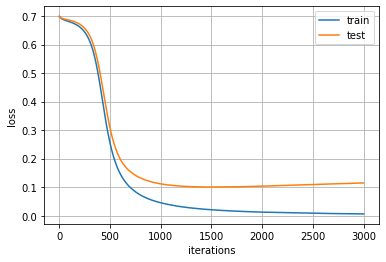

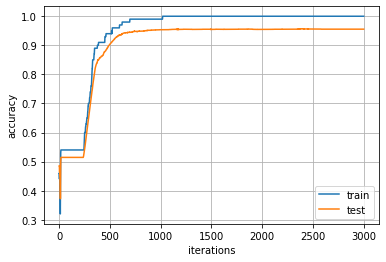

In [ ]:
plt.figure()
plt.plot(recorder.get('train_loss'), label='train')
plt.plot(recorder.get('test_loss'), label='test')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(recorder.get('train_acc'), label='train')
plt.plot(recorder.get('test_acc'), label='test')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.grid()
plt.show()

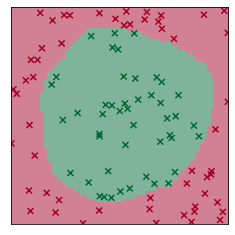

In [ ]:
plt.figure()
custom_imshow(plt.gca(), 2. * (ntks['f_hat_test'][-1] > 0) - 1)
plt.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
plt.xticks([]); plt.yticks([])
plt.show()

In [ ]:
usvs = []

for i, j in enumerate(ntks['jacobian']):
    print(f'Computing eigendecomposition ({i+1}/{len(ntks["jacobian"])})')
    u, s, v = torch.svd(j.t() / j.size(0))
    usvs.append((u, s, v))

Computing eigendecomposition (1/6)
Computing eigendecomposition (2/6)
Computing eigendecomposition (3/6)
Computing eigendecomposition (4/6)
Computing eigendecomposition (5/6)
Computing eigendecomposition (6/6)


In [ ]:
# Optionnally save - useful for higher test resolution where
# computing the eigendecomposition takes longer

# import pickle as pkl

# d = {
#     'usvs': usvs,
#     'x_train': x_train,
#     'y_train': y_train,
#     'x_test': x_test,
#     'y_test': y_test,
#     'ntks': ntks
# }

# pkl.dump(d, open('./svds.pkl', 'wb'))

# d = pkl.load(open('./svds.pkl', 'rb'))

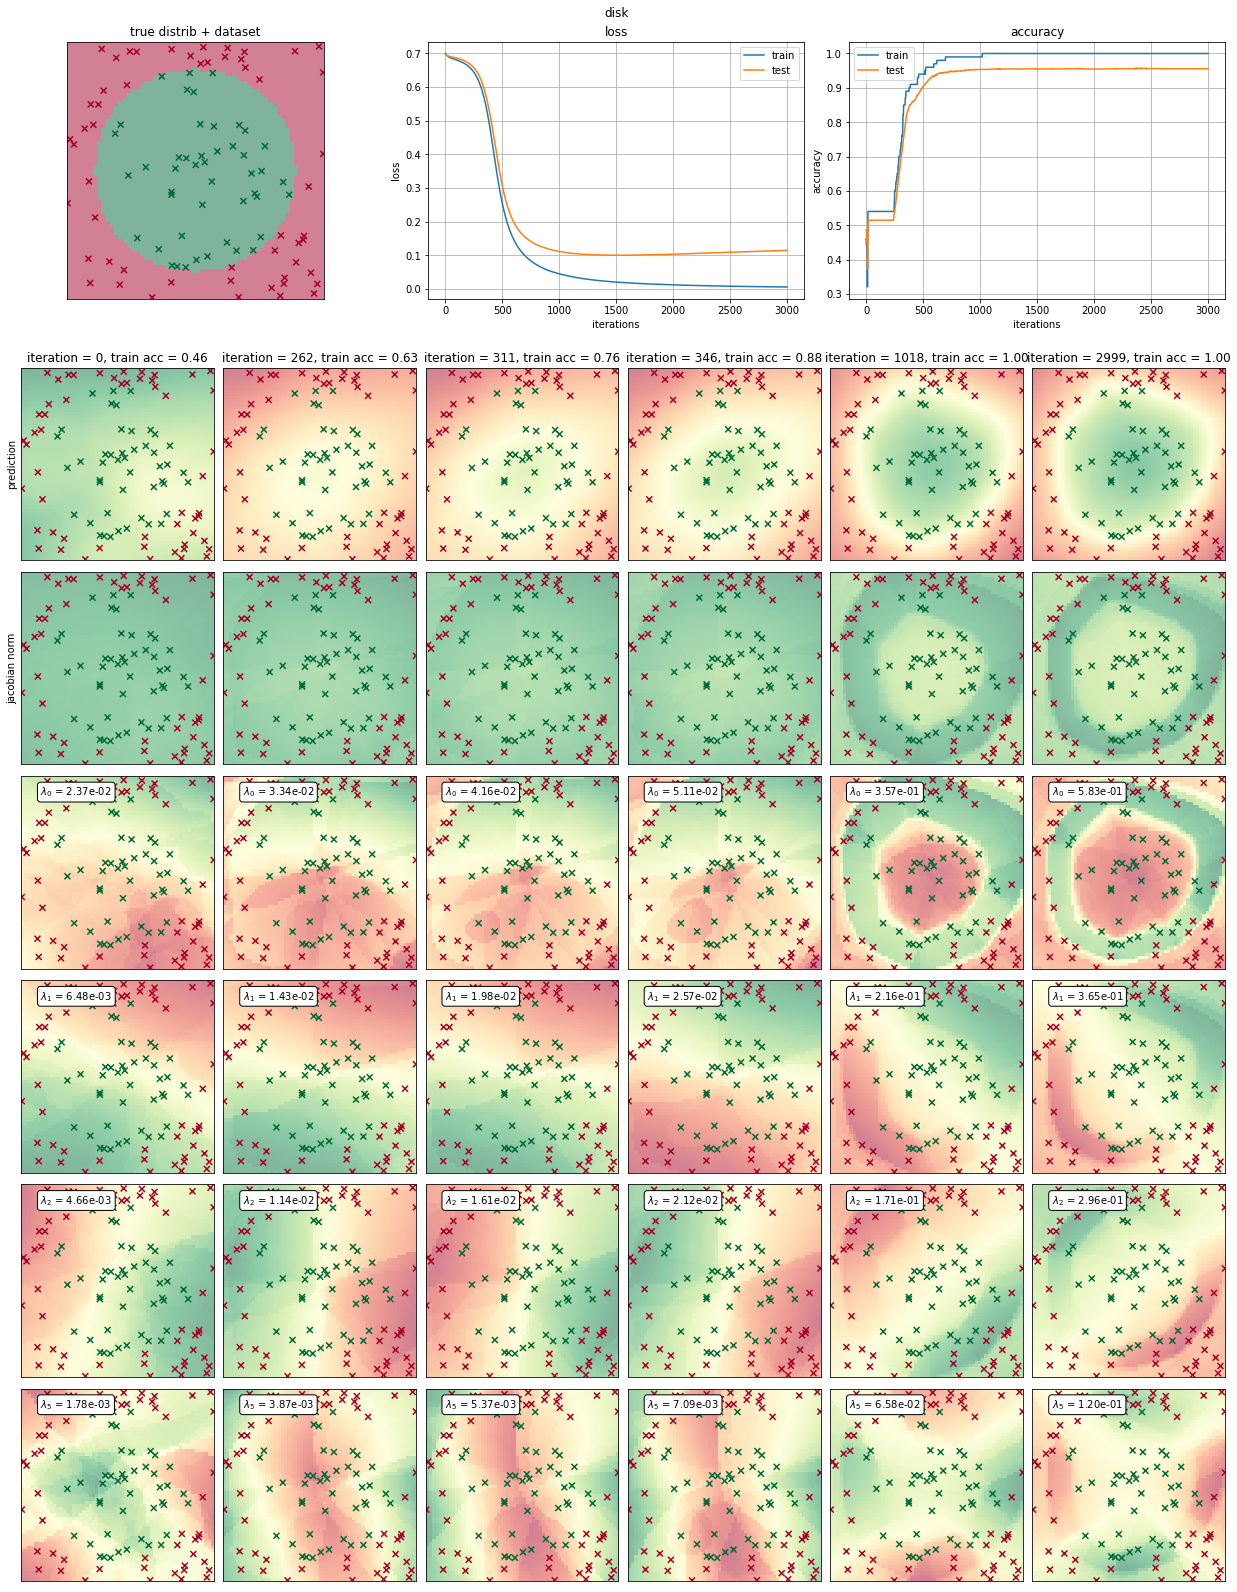

In [ ]:
mult = 3.5
evals_i = [0, 1, 2, 5]#10, 100]

fig = plt.figure(figsize=(17, 22), constrained_layout=True)
subfigs_rows = fig.subfigures(2, 1, height_ratios=[1, 4])
axes_row1 = subfigs_rows[0].subplots(1, 3)

fig.suptitle(args.dataset)

## dataset
axis = axes_row1[0]
custom_imshow(axis, y_test)
axis.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
axis.set_xticks([]); axis.set_yticks([])
axis.set_title('true distrib + dataset')

## training
axis = axes_row1[1]

axis.plot(recorder.get('train_loss'), label='train')
axis.plot(recorder.get('test_loss'), label='test')
axis.legend()
axis.set_xlabel('iterations')
axis.set_ylabel('loss')
axis.grid()
axis.set_title('loss')

axis = axes_row1[2]
axis.plot(recorder.get('train_acc'), label='train')
axis.plot(recorder.get('test_acc'), label='test')
axis.legend()
axis.set_xlabel('iterations')
axis.set_ylabel('accuracy')
axis.grid()
axis.set_title('accuracy')

## analysis
axs = subfigs_rows[1].subplots(ncols=len(usvs), nrows=len(evals_i)+2)

for i, (u, s, v) in enumerate(usvs):

    axis = axs[0, i]
    axis.set_title(f'iteration = {ntks["iterations"][i]}, train acc = {ntks["train_acc"][i]:.2f}')

    custom_imshow(axis, ntks['f_hat_test'][i], center=True)
    axis.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
    axis.set_xticks([]); axis.set_yticks([])

    axis = axs[1, i]
    custom_imshow(axis, torch.norm(ntks['jacobian'][i], dim=1), center=True)
    axis.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
    axis.set_xticks([]); axis.set_yticks([])

    for j, e_index in enumerate(evals_i):
        axis = axs[j+2, i]

        custom_imshow(axis, v[:, e_index], center=False)
        axis.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
        axis.annotate(f'$\lambda_{{ {e_index} }}$ = {s[e_index].item():.2e}', xycoords='axes fraction', xy=(.1, .9), bbox=dict(boxstyle="round", fc="w"))
        axis.set_xticks([]); axis.set_yticks([])

axs[0, 0].set_ylabel(f'prediction')
axs[1, 0].set_ylabel(f'jacobian norm')


plt.savefig(f'plot_{args.dataset}.pdf')
plt.show()

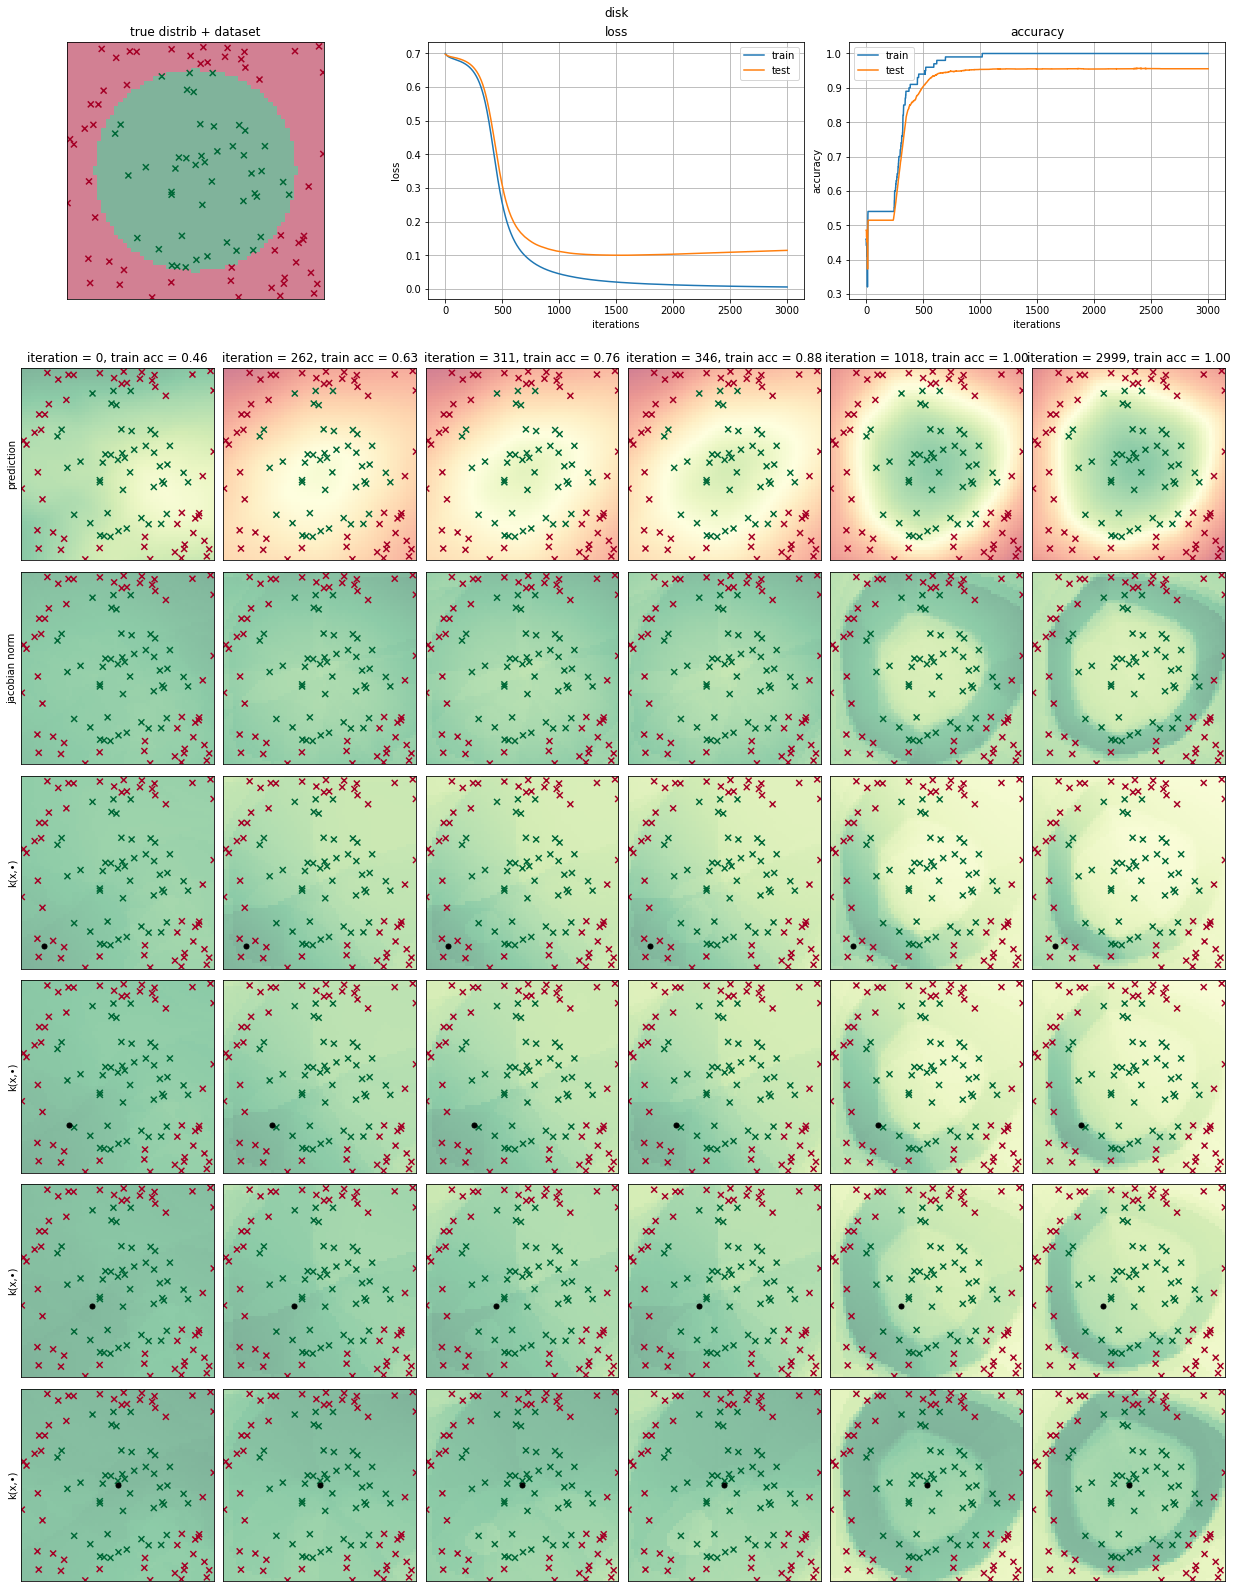

In [ ]:
mult = 3.5
evals_i = [0, 1, 10, 100]

fig = plt.figure(figsize=(17, 22), constrained_layout=True)
subfigs_rows = fig.subfigures(2, 1, height_ratios=[1, 4])
axes_row1 = subfigs_rows[0].subplots(1, 3)

fig.suptitle(args.dataset)

points = [(7, 7),
          (15, 15),
          (22, 22),
          (30, 30)]

## dataset
axis = axes_row1[0]
custom_imshow(axis, y_test)
axis.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
axis.set_xticks([]); axis.set_yticks([])
axis.set_title('true distrib + dataset')

## training
axis = axes_row1[1]

axis.plot(recorder.get('train_loss'), label='train')
axis.plot(recorder.get('test_loss'), label='test')
axis.legend()
axis.set_xlabel('iterations')
axis.set_ylabel('loss')
axis.grid()
axis.set_title('loss')

axis = axes_row1[2]
axis.plot(recorder.get('train_acc'), label='train')
axis.plot(recorder.get('test_acc'), label='test')
axis.legend()
axis.set_xlabel('iterations')
axis.set_ylabel('accuracy')
axis.grid()
axis.set_title('accuracy')

## analysis
axs = subfigs_rows[1].subplots(ncols=len(usvs), nrows=len(evals_i)+2)

for i, (u, s, v) in enumerate(usvs):

    axis = axs[0, i]
    axis.set_title(f'iteration = {ntks["iterations"][i]}, train acc = {ntks["train_acc"][i]:.2f}')

    custom_imshow(axis, ntks['f_hat_test'][i], center=True)
    axis.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
    axis.set_xticks([]); axis.set_yticks([])

    axis = axs[1, i]
    custom_imshow(axis, torch.norm(ntks['jacobian'][i], dim=1), center=True)
    axis.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
    axis.set_xticks([]); axis.set_yticks([])

    jacs = ntks['jacobian'][i]
    jacs_mat = jacs.view(args.test_resolution, args.test_resolution, -1)

    for j, p_xy in enumerate(points):
        axis = axs[j+2, i]

        jac_this = jacs_mat[p_xy[0], p_xy[1], :]
        k_xy = torch.mv(jacs, jac_this)

        custom_imshow(axis, k_xy, center=True)
        axis.scatter(x_train[:, 0].cpu(), x_train[:, 1].cpu(), c=y_train.cpu(), marker='x', cmap=cmap)
        axis.set_xticks([]); axis.set_yticks([])
        axis.scatter([p_xy[0] / 30 - 1], [p_xy[1] / 30 - 1], c='black', s=25)

axs[0, 0].set_ylabel(f'prediction')
axs[1, 0].set_ylabel(f'jacobian norm')
for j in range(len(points)):
    axs[j+2, 0].set_ylabel('k(x,•)')


plt.savefig(f'plot_{args.dataset}.pdf')
plt.show()